# LightHearted: Tutorial

This notebook presents a walkthrough of how to use the LightHearted framework to create a lighting design. For this, we use the design employed in a concert with the Aarhus Symphony Orchestra (ASO) for a performance of Tchaikovsky's Romeo and Juliet Fantasy Overture. The script containing this can be found in the examples folder . By the end of this tutorial you should hopefully be familiar with the use of the five main objects used in a LightHearted workflow:

- FIFOBuffer - Used to contain and process ECG signals
- LightingArray - Used to define a lighting group and send them commands
- MappingArray - Used to contain and reduce data to be mapped from multiple ECG devices and derive spatial expansions that can be mapped to LightingArrays
- ContinuousMapper - Used to define the relationship between a MappingArray and a LightingArray
- TriggerMapper - Used to define event based triggers between FIFOBuffers and LightingArrays

## 1. Basics

### 1.1 Workflow

The general workflow for LightHearted is as follows:

1. ECG signals are transported over OSC and received in a script. For each signal, a first-in-first-out (FIFO) buffer is instanced.
2. Optional chains of transforms are applied to each FIFOBuffer, and placed into new instances of FIFOBuffers (e.g. filtering, QRS extraction).
3. Signal or transformed buffers can be assigned to instances of MappingArrays. These take multiple FIFOBuffers, with their position in the array corresponding to a spatial position. Each buffer is reduced to a single value using a chain of functions (e.g. mean, the newest value in the array).
4. The MappingArray can be used to generate spatial expansions, that is expanding the MappingArray to match the shape of a LightingArray. This can be done through a user-defined function (e.g. linear interpolation, filling the expansion with set values). A single MappingArray can generate multiple spatial expansions if the data is to be used to generate lighting across multiple lighting groups.
5. Groups of lighting fixtures are defined as LightingArray objects. If interpolations are to be used to generate spatial expansions in the MappingArray, anchor positions in the LightingArray can also be defined. These correspond to the spatial positions of the values in the MappingArray before expansion.
6. ContinuousMappers can be instanced to define the relationship between the MappingArrays/spatial expansions and the LightingArrays. These result in the intensity and colour parameters of the LightingArray being continuously updated.
7. The LightingArray can be used to send commands to the installed lighting system in the concert hall, sending the corresponding parameter messages to the fixtures.
8. TriggerMapper objects can be defined to generate action based mappings between FIFOBuffers. These take one buffer as a reference and another as a query (e.g. a signal buffer could be a reference, and a buffer of peaks indices could be a query). A chain of trigger functions can be defined, as long as the final function returns a bool (e.g. has a peak index in the peak buffer crossed a specified index in the signal buffer). Upon return of a True value from the trigger function chain, an action function is triggered.

These should be implemented in a single script, encapsulated in async functions. Familiarity with the asyncio library is assumed. If there are many parameters to define, it is also recommeded to make use of a config script, which is imported into the main script.

### 1.2 The ASO Design

The ASO design consists of three primary lighting groups and corresponding mappings:

1. A group of 14 horizonally organised LEDs reflected from the organ directly behind the stage. For this, we derive heart rate values from the ECG signals, interpolate the values to match the number of LEDs, and use these to drive shifts in RGB values within a defined colourmap. We also use the detection of an R-Peak to trigger changes in the lighting intensity.
2. A group of 36 baluster leds, mounted in the balconies around the audience. For these, we use the derived heart rate from the conductor's ECG to generate shifts in RGB within the colourmap.
3. A horizontally arranged row of 15 background LEDs, mounted in the wall to the rear of the stage. We use these to display the current colourmap.

A video of the design in action can be found [here](https://osf.io/c2zt9/?view_only=23cc8068eba347b2a7cc4f6dbc77adc3).

## 2. First Steps

### 2.1 Setting Up a Script

The first step is to create a new script, which we will call ASO25.py. At first, we will just import asyncio, used to define our async functions.

In [33]:
%load_ext autoreload
%autoreload 2
import asyncio

We will then define a main function, and set it to run.

In [ ]:
async def main():
    pass

if __name__ == "__main__":
    asyncio.run(main())

We will define separate processing functions, and these will be launched from the main function. We will also initialise all of our LightHearted objects within the main function.

The next step is to define identifiers for each of the ECG signals that we will use. It is important to note that these identifiers will be used across the design, e.g. as osc addresses, as dictionary keys, and data labels. For the purposes of this example, we will use four ECG signals - from the conductor, the french horn, the concertmaster, and an audience member. We will labels these ```"conductor"```, ```"brs"```, ```"vn1"```, and ```"aud"``` respectively. We will define them as a list ```osc_addresses```, as their first use will be in the reception of the ECG data over OSC. We can place this line in the main function.

In [2]:
osc_addresses = ["/aud", "/brs", "/conductor", "/vn1"]

### 2.2 Getting Data Into the Script

The next step is to start receiving data in the script. We can either receive data from four ECG devices over OSC, or we can use the ```csv_simulator``` to read recorded ECG csv files in realtime. We will walk through both of these.

#### 2.2.1 Sending Data from an ECG Sensor

LightHearted is intented to be device agnostic, that is that it can function with any ECG device. In view of this, ECG data is expected to be received over OSC messages. Currently, LightHearted contains inbuilt support for devices from [SIFILabs](https://sifilabs.com/). This can be accessed through running the script ```sifilabs.py``` in the ```acquisition``` module. This will connect to and stream an arbritrary number of SIFILabs devices over OSC.

The script is parameterised in ```sifi_config.py```. The most important variable here is the ```mac_dict```, which provides the device identifier and MAC address. It is important to note that the keys in the ```mac_dict``` should match the OSC addresses set in the LightHearted design. So in our case, we would parameterise it as follows:

In [ ]:
mac_dict = { 
    "/aud": "MACADDRESS1",
    "/brs": "MACADDRESS2",
    "/conductor": "MACADDRESS3",
    "/vn1": "MACADDRESS4"
    }

The IP and port of the server receiving the data (in our case to be used in our design) are also set here in the ```sifi_receiver_ip``` and ```sifi_receiver_port``` variables.

#### 2.2.2 Reading a CSV File in Realtime

LightHearted also supports the use of previously recorded ECG data. This is done through the ```csv_simulator``` module. All the csv files should be placed in a single directory, and importantly, their names should match the OSC addresses specified above. In our case, our four csv files should be named:

- ```aud.csv```
- ```brs.csv```
- ```conductor.csv```
- ```vn1.csv```

The reader is parameterised through ```sim_config.py```. The ```filepath``` variable specifies the directory in which the csv files are located. If ```None``` is provided, this defaults to the ```csv``` directory. The ```column``` specifies the column of the csv to read from. The ```csv_sr``` set the speed of playback.

Both of these methods can be integrated into a LightHearted script by calling them as a process within the script. In our case, we will use the csv_reader and define a function where it can run on the press of the ```'r'``` key.

In [ ]:
import aioconsole
from multiprocessing import Process
from csv_simulator.csv_simulator import csv_sim

async def listen_for_commands() -> None:
    """
    Asynchronously listens for user commands from the console.
    - 'q': Cancels all running tasks and stops the event loop (quits the program).
    - 'r': Starts the CSV simulator in a separate process.

    Parameters
    ----------
    None
    """
    while True:
        user_input = await aioconsole.ainput("Enter 'r' to run simulator: ")
        if user_input.lower() == 'r':
            p_csv = Process(target=csv_sim)
            p_csv.start()

In our main block, we now define a task for the listener.

In [ ]:
async def main():

    # Define the OSC addresses
    osc_addresses = ["/aud", "/brs", "/conductor", "/vn1"]

    # Start the command listener task
    task_commands = asyncio.create_task(listen_for_commands())
    all_tasks = [task_commands]

    await asyncio.gather(*all_tasks)

We will now be able to launch the csv reader on the press of the ```'r'``` key.

#### 2.2.3 Receiving Data in the Script

So how do we receive this data in our script? There are several inbuilt functions to setup an osc server and process incoming data. However, first we need to initialise a location for the data to be placed. This is where we are introduced to the first key object for a LightHearted design - the ```FIFOBuffer``` object. This is a buffer of a fixed size, which operates on a first-in-first-out principle, meaning that as data is added to the buffer that exceeds the buffer length, the oldest data in the buffer is deleted. We instantiate the buffer with a single argument, the size of the buffer.

In [3]:
import sys
sys.path.append("../")
from acquisition.fifo_buffer import FIFOBuffer

buffer = FIFOBuffer(10)

We can add data to the buffer using the ```enqueue``` method. ```Int```, ```Float```, ```List```, ```Tuple``` and ```np.ndarray``` are accepted as valid to enqueue. Lists, tuples, and numpy arrays are flattened before they are enqueued. The ```get_buffer``` method returns the current buffer.

In [4]:
# int
buffer.enqueue(1)
print(f"int: {buffer.get_buffer()}")
# float
buffer.enqueue(1.5)
print(f"float: {buffer.get_buffer()}")
# list
buffer.enqueue([2, 3, 4])
print(f"list: {buffer.get_buffer()}")
# tuple
buffer.enqueue((5, 6))
print(f"tuple: {buffer.get_buffer()}")
# np.ndarray
import numpy as np
buffer.enqueue(np.array([7, 8, 9]))
print(f"np.ndarray: {buffer.get_buffer()}")

# first in, first out
buffer.enqueue(10)
print(f"FIFO (1 is removed, 10 is added): {buffer.get_buffer()}")

int: [1.]
float: [1.  1.5]
list: [1.  1.5 2.  3.  4. ]
tuple: [1.  1.5 2.  3.  4.  5.  6. ]
np.ndarray: [1.  1.5 2.  3.  4.  5.  6.  7.  8.  9. ]
FIFO (1 is removed, 10 is added): [ 1.5  2.   3.   4.   5.   6.   7.   8.   9.  10. ]


The buffer can be cleared with the ```clear_buffer``` method.

In [5]:
buffer.clear_buffer()
print(f"Buffer after clearing: {buffer.get_buffer()}")

Buffer after clearing: []


The ```set_buffer``` method clears and sets the buffer to the current values. The ```resize_buffer``` argument can reset the fixed length of the buffer to the new input. ```get_size``` returns the current size of the buffer and ```get_max_size``` returns the fixed length. ```is_full``` returns a boolean if the the buffer has reached its fixed length.

In [6]:
buffer.enqueue(np.arange(10))
print(f"Buffer after enqueing: {buffer.get_buffer()}")
print("\n")

buffer.set_buffer(np.arange(5), resize_buffer=False)
print(f"Buffer after setting: {buffer.get_buffer()}")
print(f"Buffer size: {buffer.get_size()}")
print(f"Buffer max size: {buffer.get_max_size()}")
print(f"Is buffer full? {buffer.is_full()}")
print("\n")

buffer.set_buffer(np.arange(5), resize_buffer=True)
print(f"Buffer after setting with resize: {buffer.get_buffer()}")
print(f"Buffer size after resize: {buffer.get_size()}")
print(f"Buffer max size after resize: {buffer.get_max_size()}")
print(f"Is buffer full after resize? {buffer.is_full()}")

Buffer after enqueing: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


Buffer after setting: [0. 1. 2. 3. 4.]
Buffer size: 5
Buffer max size: 10
Is buffer full? False


Buffer after setting with resize: [0. 1. 2. 3. 4.]
Buffer size after resize: 5
Buffer max size after resize: 5
Is buffer full after resize? True


We can now instantiate four ```FIFOBuffers``` in our main loop, which we will set to have a length of 256, or one second at a sampling rate of 256Hz. We will store these in a dictionary, with the corresponding OSC address as the key.

In [ ]:
async def main():

    # Define the OSC addresses
    osc_addresses = ["/aud", "/brs", "/conductor", "/vn1"]

    # Create FIFO buffers for each OSC address
    ecg_buffer_dict = {address: FIFOBuffer(256) for address in osc_addresses}

    # Start the command listener task
    task_commands = asyncio.create_task(listen_for_commands())
    all_tasks = [task_commands]

    await asyncio.gather(*all_tasks)

We can now set up a server to listen for incoming OSC messages and enque the received data in the correct buffer. We can do this with the ```setup_osc_server``` method. This takes four arguments: an ip address and port for the server, the list of osc addresses and the dictionary of corresponding FIFOBuffers.

In [ ]:
from utils.utils import setup_osc_server

async def main():

    # Define the OSC addresses
    osc_addresses = ["/aud", "/brs", "/conductor", "/vn1"]

    # Set the OSC server IP and port
    osc_ip = "127.0.0.1"
    osc_port = 13000

    # Create FIFO buffers for each OSC address
    ecg_buffer_dict = {address: FIFOBuffer(256) for address in osc_addresses}

    # Set up the OSC server to listen for incoming messages
    setup_osc_server(osc_ip, osc_port, osc_addresses, ecg_buffer_dict)

    # Start the command listener task
    task_commands = asyncio.create_task(listen_for_commands())
    all_tasks = [task_commands]

    await asyncio.gather(*all_tasks)

We now also need to initiate a task to process the OSC messages (i.e. enqueue received data in the corresponding buffer). For this, we can use the inbuilt function ```osc_loop```.

In [ ]:
from utils.utils import osc_loop

async def main():

    # Define the OSC addresses
    osc_addresses = ["/aud", "/brs", "/conductor", "/vn1"]

    # Set the OSC server IP and port
    osc_ip = "127.0.0.1"
    osc_port = 13000

    # Create FIFO buffers for each OSC address
    ecg_buffer_dict = {address: FIFOBuffer(256) for address in osc_addresses}

    # Set up the OSC server to listen for incoming messages
    setup_osc_server(osc_ip, osc_port, osc_addresses, ecg_buffer_dict)

    # Start the command listener task
    task_commands = asyncio.create_task(listen_for_commands())

    # Start the OSC loop to process incoming messages
    task_osc_loop = asyncio.create_task(osc_loop())

    all_tasks = [task_commands, task_osc_loop]

    await asyncio.gather(*all_tasks)

Now the incoming data will be continuously enqueued in the FIFOBuffers and we can start to use it to generate the lighting design.

## 3. Processing Data

The first step before we begin generating a lighting design through mappings is to process the data that we receive in our ```FIFOBuffers```. LightHearted is designed to be flexible in these processing steps, and therefore processing is centred around two main methods of the ```FIFOBuffer``` object: ```transform``` and ```transform_tick```.

### 3.1 The FIFOBuffer Transform Method

The ```transform``` method is one of the key methods in LightHearted. LightHearted by default does not apply any processing or pre-processing such as filtering to the received ECG signals. The ```transform``` method is intended as a way through which processing functions can be applied in a user-defined manner. The function takes as its arguments a series of functions, with corresponding arguments and keyword arguments. These can be any Python function, so long as the function's first argument is an array-like. For a simple demonstration, we can perform a simple transform that multiplies the buffer by a factor of two.

In [7]:
# define a simple multiplication function
def multiply(data, factor=2):
    return data * factor

# instiatiate a FIFOBuffer
buffer = FIFOBuffer(10)

# fill the buffer with some data
buffer.enqueue(np.arange(10))

# define functions, arguments, and keyword arguments
functions = [multiply]
args = [()]
kwargs = [{"factor": 2}]

# apply the transform method
result = buffer.transform(functions, args, kwargs)
print(f"Buffer: {buffer.get_buffer()}")
print(f"Transformed Buffer: {result}")

Buffer: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


This also works if we use the args instead of the kwargs. Note that the args are taken as a tuple, so require a comma delimiter after single values.

In [8]:
# instiatiate a FIFOBuffer
buffer = FIFOBuffer(10)

# fill the buffer with some data
buffer.enqueue(np.arange(10))

# define functions, arguments, and keyword arguments
functions = [multiply]
args = [(2,)]
kwargs = [{}]

# apply the transform method
result = buffer.transform(functions, args, kwargs)
print(f"Buffer: {buffer.get_buffer()}")
print(f"Transformed Buffer: {result}")

Buffer: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


We can also apply a chain of functions. Let's try applying a multiplication and filter function to some noise.

Text(0.5, 1.0, 'Transformed Data')

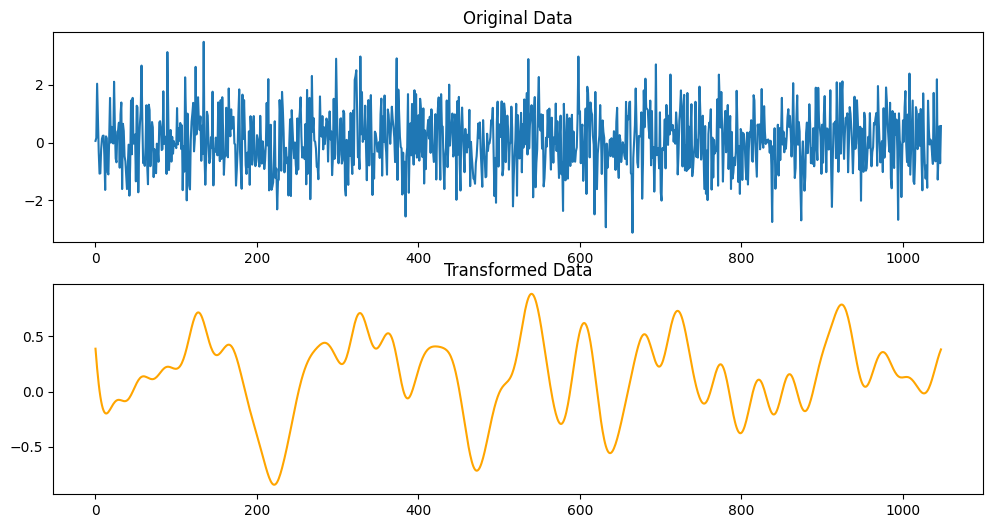

In [9]:
from utils.utils import filter

# instiatiate a FIFOBuffer
buffer = FIFOBuffer(1048)

# fill the buffer with some noise
buffer.enqueue(np.random.normal(size=1048))

# define functions, arguments, and keyword arguments
functions = [multiply, filter]
args = [(), ()]
kwargs = [{"factor": 2}, {"order": 3, "cf": 5, "type": "low", "fs": 256}] # filter parameters - order, cutoff frequency, type, and sampling frequency

# apply the transform method
result = buffer.transform(functions, args, kwargs)

import matplotlib.pyplot as plt
# plot the original and transformed data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(buffer.get_buffer(), label='Original Data')
plt.title('Original Data')
plt.subplot(2, 1, 2)
plt.plot(result, label='Transformed Data', color='orange')
plt.title('Transformed Data')

We can also use the special arguments ```"min"```, ```"max"```, ```"mean"```, and ```"std"``` to pass statistical properties of the signal as arguments to any of the functions. We can use this here, for example, to normalise our signal by diving by its maximum value.

Text(0.5, 1.0, 'Transformed Data')

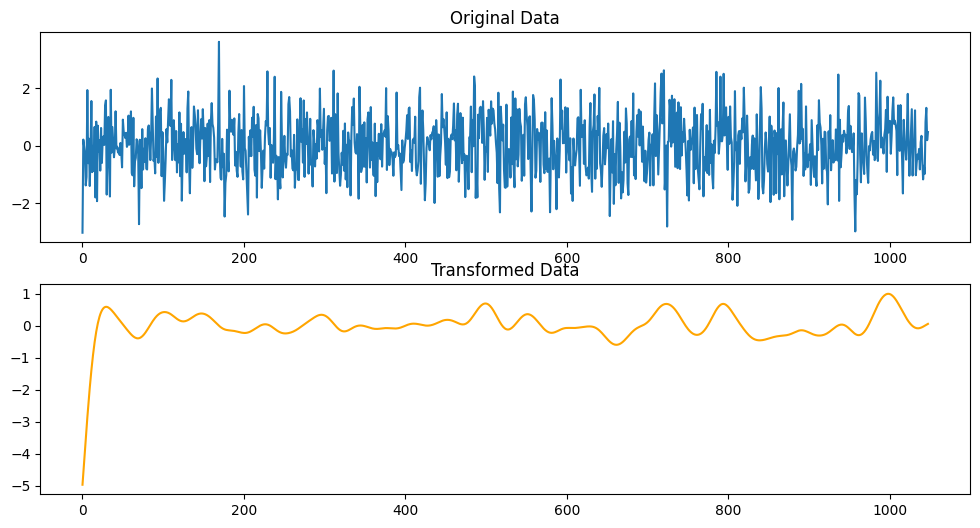

In [10]:
def divide(data, factor=2):
    return data / factor

# instiatiate a FIFOBuffer
buffer = FIFOBuffer(1048)

# fill the buffer with some noise
buffer.enqueue(np.random.normal(size=1048))

# define functions, arguments, and keyword arguments
functions = [multiply, filter, divide]
args = [(), (), ()]
kwargs = [{"factor": 2}, {"order": 3, "cf": 5, "type": "low", "fs": 256}, {"factor":"max"}]

# apply the transform method
result = buffer.transform(functions, args, kwargs)

import matplotlib.pyplot as plt
# plot the original and transformed data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(buffer.get_buffer(), label='Original Data')
plt.title('Original Data')
plt.subplot(2, 1, 2)
plt.plot(result, label='Transformed Data', color='orange')
plt.title('Transformed Data')

In the case that a function returns multiple values and we require a specific return value for the next function in the chain, we can also specify the output indices for each function.

Text(0.5, 1.0, 'Transformed Data')

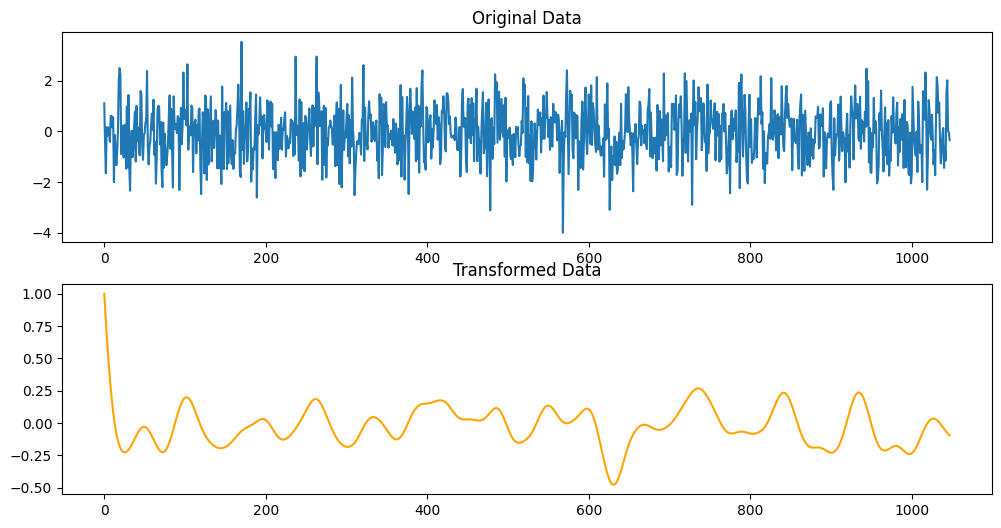

In [11]:
def multiply(data, factor=2):
    return None, None, data* factor # add None for the first two outputs

# instiatiate a FIFOBuffer
buffer = FIFOBuffer(1048)

# fill the buffer with some noise
buffer.enqueue(np.random.normal(size=1048))

# define functions, arguments, and keyword arguments
functions = [multiply, filter, divide]
args = [(), (), ()]
kwargs = [{"factor": 2}, {"order": 3, "cf": 5, "type": "low", "fs": 256}, {"factor":"max"}]

# specify output indices for each function
output_indices = [2, None, None]  # Use the third output of multiply

# apply the transform method
result = buffer.transform(functions, args, kwargs, output_indices=output_indices) # pass output_indices to the transform method

import matplotlib.pyplot as plt
# plot the original and transformed data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(buffer.get_buffer(), label='Original Data')
plt.title('Original Data')
plt.subplot(2, 1, 2)
plt.plot(result, label='Transformed Data', color='orange')
plt.title('Transformed Data')

It is important to note that the transform function returns a numpy array (in this case at least). So if you need the transform in a ```FIFOBuffer```, you will have to instantiate a new buffer and enqueue the result. This method for applying multiple functions is central to LightHearted, and appears in other functions and objects.

#### 3.1.1 Transform Tick

When working with signals in real-time, timing becomes important. We don't want to use computational resources to repeatedly perform transforms when no new data has arrived. Equally, we might only need to perform the transform at set time intervals. To aid in timing, the ```transform``` method has a variant ```transform_tick``` which can handle timing. The ```transform_tick``` method operates identically to the ```transform``` method. However, it can take two additional arguments. ```mode``` specifies whether the transform should take place when a new value is enqueued in the buffer (```"update"```) or at a set time inverval (```"time"```). In ```"time"``` mode, and additional argument ```interval``` can be passed, which specifies the update time in milliseconds. In the case that the function is called and the ticks requirements have not been met, the function returns ```None```. We can first demonstrate in ```"update"``` mode.

In [12]:
def multiply(data, factor=2):
    return data* factor

# instiatiate a FIFOBuffer
buffer = FIFOBuffer(10)

# fill the buffer with some data
buffer.enqueue(np.arange(10))

# define functions, arguments, and keyword arguments
functions = [multiply]
args = [()]
kwargs = [{"factor": 2}]

# define some data to enqueue
data_to_enqueue = np.arange(90, 100)

# apply the transform method in a loop
for i, data in enumerate(data_to_enqueue):

    if i%2 == 0: # only enqueue every second data
        # enqueue the data
        buffer.enqueue(data)
        print(f"Enqueued: {data}")
        
    # apply the transform method
    result = buffer.transform_tick(functions, args, kwargs, mode="update")
    print(f"Index: {i}, Data: {data}, Transformed Buffer: {result}")

Enqueued: 90
Index: 0, Data: 90, Transformed Buffer: [  2.   4.   6.   8.  10.  12.  14.  16.  18. 180.]
Index: 1, Data: 91, Transformed Buffer: None
Enqueued: 92
Index: 2, Data: 92, Transformed Buffer: [  4.   6.   8.  10.  12.  14.  16.  18. 180. 184.]
Index: 3, Data: 93, Transformed Buffer: None
Enqueued: 94
Index: 4, Data: 94, Transformed Buffer: [  6.   8.  10.  12.  14.  16.  18. 180. 184. 188.]
Index: 5, Data: 95, Transformed Buffer: None
Enqueued: 96
Index: 6, Data: 96, Transformed Buffer: [  8.  10.  12.  14.  16.  18. 180. 184. 188. 192.]
Index: 7, Data: 97, Transformed Buffer: None
Enqueued: 98
Index: 8, Data: 98, Transformed Buffer: [ 10.  12.  14.  16.  18. 180. 184. 188. 192. 196.]
Index: 9, Data: 99, Transformed Buffer: None


It is important to note here that even though the ```transform_tick``` method is called, internally it does not apply of the functions, saving computational resourses. This is useful while calling the function in ```while``` loops within async functions, as is the common use case in LightHearted scripts. We can also run this in ```"time"``` mode.

In [13]:
import time

# instiatiate a FIFOBuffer
buffer = FIFOBuffer(10)

# fill the buffer with some data
buffer.enqueue(np.arange(10))

# define functions, arguments, and keyword arguments
functions = [multiply]
args = [()]
kwargs = [{"factor": 2}]

# define some data to enqueue
data_to_enqueue = np.arange(90, 100)

# apply the transform method in a loop
now = time.perf_counter()
duration = 10

while time.perf_counter() - now <= duration:
    
    result = buffer.transform_tick(functions, args, kwargs, mode="time", interval=500) # 500 ms interval

    if result is not None: # check if transform was applied
        print(f"Time Elapsed: {time.perf_counter() - now:.2f} seconds, Transformed Buffer: {result}")

Time Elapsed: 0.00 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 0.50 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 1.00 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 1.50 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 2.00 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 2.50 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 3.00 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 3.50 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 4.00 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 4.50 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 5.00 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elaps

##### 3.1.1.1 Transform Tick and Asyncio Sleep

LightHearted is intended to be run within asyncronous functions using the asyncio library. The asyncio library contains its own function which can be used to aid in timing operations: ```asyncio.sleep```. Without getting into too much detail, this function causes the current coroutine to sleep for a specified amount of time, freeing up resources for other tasks in the main event loop in the meantime (see [here](https://docs.python.org/3/library/asyncio-task.html#sleeping)). A common usecase, and how we use it in LightHearted, is to time an async function that we know only needs to be called at specified time intervals in a ```while``` loop. For example, using the simple ```transform``` method, we could time a buffer transform to occur once a second as follows.

In [ ]:
# define an asynchronous function to transform the buffer once every second
async def transform_buffer(buffer):

    functions = [multiply]
    args = [()]
    kwargs = [{"factor": 2}]

    while True:

        result = buffer.transform(functions, args, kwargs)

        await asyncio.sleep(1)  # Sleep for 1 second

async def main():
    # Create FIFO buffer
    buffer = FIFOBuffer(10)

    # Fill the buffer with some data
    buffer.enqueue(np.arange(10))

    # Start the transform task
    task_transform = asyncio.create_task(transform_buffer(buffer))

    await asyncio.gather(task_transform)

await main()

This has one main advantage over using the ```transform_tick``` method in ```time``` mode. Even though the ```transform_tick``` is only performing the transform at the specified time interval, the ```transform_tick``` method is still being called (returning ```None```). Although minimal, there is still a slight processing overhead associated with this. Conversely, using ```asyncio.sleep``` will only call the ```transform``` method at the specified time intervals. So why use the ```transform_tick``` method at all? Well there are several reasons. First, there might be additional processing that we wish to have performed within the asyc function at a faster rate than ```transform``` (say, for example, listening for incoming data that updates an argument for one of the transform functions). Moreover, when running the ```asyncio.sleep``` function repeatedly for longer periods of time (as in a ```while True:``` loop), slight errors can accumlate in the timing. For very time sensitive operations it is therefore preferable to use the ```transform_tick``` method. It is also possible to find a combination between these two methods to create a balance between the use of computational resources and the timing precision required. The following codeblock demonstrates the resource usage and timing for the two extreme option when making a transform every second: just using ```asyncio.sleep``` and just using ```transform_tick``` in ```time``` mode (with the ```while``` loop regulated with ```asyncio.sleep(0)```, a special usage of ```asyncio.sleep``` that immediately yields resources but also enables the immediate return to the coroutine).

In [15]:
# run a transform once per second and get 10 results using asyncio.sleep for timing

async def transform_buffer(buffer):
    
    functions = [multiply, filter, divide]
    args = [(), (), ()]
    kwargs = [{"factor": 2}, {"order": 3, "cf": 5, "type": "low", "fs": 256}, {"factor":"max"}]

    calls = 0 # variable to count the number of calls
    results = 0 # variable to count the number of results (i.e. performed transforms)
    no_results = 10 # number of results to perform before stopping
    interval_s = 1 # interval in seconds at which to perform the transform

    start = time.perf_counter() # start time for performance measurement
    
    while results < no_results: # loop until we have performed the desired number of transforms

        result = buffer.transform(functions, args, kwargs)
        calls += 1
        results += 1

        if results == 10: # stop after 10 results, avoid the last sleep
            continue
        else:
            await asyncio.sleep(interval_s) # sleep for the specified interval

    end = time.perf_counter() # end time for performance measurement

    print(f"asyncio.sleep: {calls} calls in {end-start:.2f}s, {results} transforms (intended interval {interval_s} s, actual interval {(end-start)/(no_results-1):.2f} s)")

async def main():
    # Create FIFO buffer
    buffer = FIFOBuffer(256)

    # Fill the buffer with some data
    buffer.enqueue(np.arange(256))

    # Start the transform task
    task_transform = asyncio.create_task(transform_buffer(buffer))

    await asyncio.gather(task_transform)

await main() # This will run the main function and start the asyncio event loop

asyncio.sleep: 10 calls in 9.08s, 10 transforms (intended interval 1 s, actual interval 1.01 s)


In [16]:
# run a transform once per second and get 10 results using transfom_tick for timing

async def transform_buffer_tick(buffer):

    functions = [multiply, filter, divide]
    args = [(), (), ()]
    kwargs = [{"factor": 2}, {"order": 3, "cf": 5, "type": "low", "fs": 256}, {"factor":"max"}]

    calls = 0 # variable to count the number of calls
    results = 0 # variable to count the number of results (i.e. performed transforms)
    no_results = 10 # number of results to perform before stopping
    interval_s = 1 # interval in seconds at which to perform the transform

    start = time.perf_counter() # start time for performance measurement

    while results < no_results: # loop until we have performed the desired number of transforms
        
        result = buffer.transform_tick(functions, args, kwargs, mode="time", interval=interval_s * 1000)
        calls += 1

        if result is not None: # check if the call actually yielded a transform
            results += 1

        await asyncio.sleep(0) # yield control to the event loop continuously

    end = time.perf_counter() # end time for performance measurement
    
    print(f"transform_tick: {calls} calls in {end-start:.2f}s, {results} transforms (intended interval {interval_s} s, actual interval {(end-start)/(no_results-1):.2f} s)")

async def main():
    # Create FIFO buffer
    buffer = FIFOBuffer(256)

    # Fill the buffer with some data
    buffer.enqueue(np.arange(256))

    # Start the transform task
    task_transform = asyncio.create_task(transform_buffer_tick(buffer))

    await asyncio.gather(task_transform)

await main()

transform_tick: 1146093 calls in 9.00s, 10 transforms (intended interval 1 s, actual interval 1.00 s)


We can see that even just with 10 transforms, there is a slight drift in the ```asyncio.sleep``` version resulting in these 10 transforms actually requiring 9.08 seconds. However, the ```transform``` method is only called 10 times. Conversely, the ```transform_tick``` version performs the 10 transforms in exactly 9 seconds, but the ```transform``` function is called over a million times. Finding the right balance of ```transform_ticks``` and ```asyncio.sleep``` is a central aspect of using LightHearted for designs that are either running with limitted resources or for which processing is required on a strict schedule.

With this explained, we will return to our design code, and add a function to apply a **QRS** transform to our signal buffers (a common transform used in ECG processing to create prominent peaks in the signal), have this update on the reception of new data from the sensor, and enque the transforms in a new set of buffers.

In [ ]:
from derivation.transforms import pan_tompkins # pan_tompkins QRS detection algorithm

async def transform_signals_qrs(ecg_buffer_dict, qrs_buffer_dict, osc_addresses):

    ecg_filt_low = 5 # low cutoff frequency for bandpass filter in pan_tompkins
    ecg_filt_high = 12 # high cutoff frequency for bandpass filter in pan_tompkins
    ecg_window = 0.15 # window size in seconds for pan_tompkins
    ecg_sr = 256 # sampling frequency for pan_tompkins
    
    while True:
        ecg_buffer_dict = ecg_buffer_dict.copy()  # Create a copy of the current state of the buffers to avoid race conditions
        for address in osc_addresses:
            if ecg_buffer_dict[address].get_size() > 21: # ensure there is enough data in the buffer to perform the transform
                
                # apply the QRS transform to the ECG buffer and enqueue the result in the QRS
                result = ecg_buffer_dict[address].transform_tick(
                    functions = [pan_tompkins],
                    args = [(ecg_filt_low, ecg_filt_high, ecg_window, ecg_sr)],
                    kwargs = [{}],
                    mode = "update"
                )
                if result is not None: # check if the transform was applied
                    qrs_buffer_dict[address].enqueue(result) # enqueue the result in the QRS buffer

        await asyncio.sleep(0) # yield control to the event loop continuously

async def main():

    # Define the OSC addresses
    osc_addresses = ["/aud", "/brs", "/conductor", "/vn1"]

    # Set the OSC server IP and port
    osc_ip = "127.0.0.1"
    osc_port = 13000

    # Create FIFO buffers for each OSC address
    ecg_buffer_dict = {address: FIFOBuffer(256) for address in osc_addresses}
    qrs_buffer_dict = {address: FIFOBuffer(256) for address in osc_addresses}

    # Set up the OSC server to listen for incoming messages
    setup_osc_server(osc_ip, osc_port, osc_addresses, ecg_buffer_dict)

    # Start the command listener task
    task_commands = asyncio.create_task(listen_for_commands())

    # Start the OSC loop to process incoming messages
    task_osc_loop = asyncio.create_task(osc_loop())

    # Start the QRS transform task
    task_qrs_transform = asyncio.create_task(transform_signals_qrs(ecg_buffer_dict, qrs_buffer_dict, osc_addresses))

    all_tasks = [task_commands, task_osc_loop, task_qrs_transform]

    await asyncio.gather(*all_tasks)

We would also like to derive the heart rate from these **QRS** buffers, so will create an additional function to do this through peak detection and place these into a further set of buffers. We will only derive the heart rate once per second, using the ```transform_tick``` method.

In [ ]:
from derivation.heart_rate import heart_rate # heart rate derivation function - finds peaks in a signal averaged over a window

async def transform_signals_qrs(ecg_buffer_dict, qrs_buffer_dict, osc_addresses):

    ecg_filt_low = 5 # low cutoff frequency for bandpass filter in pan_tompkins
    ecg_filt_high = 12 # high cutoff frequency for bandpass filter in pan_tompkins
    ecg_window = 0.15 # window size in seconds for pan_tompkins
    ecg_sr = 256 # sampling frequency for pan_tompkins
    
    while True:
        ecg_buffer_dict = ecg_buffer_dict.copy()  # Create a copy of the current state of the buffers to avoid race conditions
        for address in osc_addresses:
            if ecg_buffer_dict[address].is_full(): # ensure there is enough data in the buffer to perform the transform
                
                # apply the QRS transform to the ECG buffer and enqueue the result in the QRS
                result = ecg_buffer_dict[address].transform_tick(
                    functions = [pan_tompkins],
                    args = [(ecg_filt_low, ecg_filt_high, ecg_window, ecg_sr)],
                    kwargs = [{}],
                    mode = "update"
                )
                if result is not None: # check if the transform was applied
                    qrs_buffer_dict[address].enqueue(result) # enqueue the result in the QRS buffer

        await asyncio.sleep(0) # yield control to the event loop continuously

async def derive_heart_rate(qrs_buffer_dict, heart_rate_buffer_dict, osc_addresses):

    hr_window = 1 # window size in seconds for heart rate derivation
    ecg_sr = 256 # sampling frequency for heart rate derivation

    while True:
        qrs_buffer_dict = qrs_buffer_dict.copy()  # Create a copy of the current state of the buffers to avoid race conditions
        for address in osc_addresses:
            if qrs_buffer_dict[address].is_full(): # ensure there is enough data in the buffer to derive the heart rate
                result = qrs_buffer_dict[address].transform_tick(
                    functions = [heart_rate],
                    args = [(hr_window, ecg_sr)],
                    kwargs = [{}],
                    mode = "time",
                    interval=1000,  # 1 second interval for heart rate calculation
                    output_indices=[1]  # specify the output index for the heart rate
                )
                if result is not None:  # check if the transform was applied
                    heart_rate_buffer_dict[address].enqueue(result) # enqueue the result in the heart rate buffer

        await asyncio.sleep(0) # yield control to the event loop continuously


async def main():

    # Define the OSC addresses
    osc_addresses = ["/aud", "/brs", "/conductor", "/vn1"]

    # Set the OSC server IP and port
    osc_ip = "127.0.0.1"
    osc_port = 13000

    # Create FIFO buffers for each OSC address
    ecg_buffer_dict = {address: FIFOBuffer(256) for address in osc_addresses}
    qrs_buffer_dict = {address: FIFOBuffer(256) for address in osc_addresses}
    heart_rate_buffer_dict = {address: FIFOBuffer(10) for address in osc_addresses} # heart rate buffers take the previous 10 derived heart rates

    # Set up the OSC server to listen for incoming messages
    setup_osc_server(osc_ip, osc_port, osc_addresses, ecg_buffer_dict)

    # Start the command listener task
    task_commands = asyncio.create_task(listen_for_commands())

    # Start the OSC loop to process incoming messages
    task_osc_loop = asyncio.create_task(osc_loop())

    # Start the QRS transform task
    task_qrs_transform = asyncio.create_task(transform_signals_qrs(ecg_buffer_dict, qrs_buffer_dict, osc_addresses))

    # Start the heart rate derivation task
    task_heart_rate = asyncio.create_task(derive_heart_rate(qrs_buffer_dict, heart_rate_buffer_dict, osc_addresses))

    all_tasks = [task_commands, task_osc_loop, task_qrs_transform, task_heart_rate]

    await asyncio.gather(*all_tasks)

## 4 Implementing a Lighting Design on the Organ LEDs

Now that we have have data coming into our ```FIFOBuffers```, are applying transforms to the buffers, and deriving features from the transforms, we can start to consider how we can use these to drive changes in the stage lighting. In LightHearted, we can achieve this with two styles of mapping: **continuous mappings**, in which lighting parameters are continuously altered based up incoming signal data, and **trigger mappings**, in which events in the signal can be defined and used to tigger single actions. We will use both of these styles of mapping to drive changes in 14 LEDs located in the organ behind orchestra. We will use a continuous mapping to drive changes in the organ LED colours, interpolating between the derived heart rates of all four of the signals to create continuously shifting flows of colour across the LEDs. We will use a trigger mapping to generate changes in LED intensity based upon the detection of a peak in the buffer.

Four new objects will be introduced in this section: ```LightingArray```, ```MappingArray```, ```ContinuousMapper```, and ```TriggerMapper```. The ```LightingArray``` object is key to both styles of mapping. For continuous mappings, it works together with the ```MappingArray``` and ```ContinuousMapper``` objects. For trigger mappings, it works together with the ```FIFOBuffer``` and ```TiggerMapper``` objects.

### 4.1 Defining a Lighting Array

The ```LightingArray``` object stores and sets colour and intensity parameters for a group of LED fixtures. It can also send commands to these fixtures to generate changes in the stage lighting. A ```LightingArray``` object can be instanced with just an array-like of fixture IDs. In our case, the organ LEDs are fixtures 401 to 414.

In [14]:
from mapping.lighting_array import LightingArray

organ_leds = LightingArray(np.arange(401, 415))  # Organ LEDs are fixtures 401 to 414
print(f"Organ LED Fixture IDs: {organ_leds.get_fixtures()}")

Organ LED Fixture IDs: [401 402 403 404 405 406 407 408 409 410 411 412 413 414]


The ```LightingArray``` holds values for the red, green, blue, and white channel of each LED, as well as its intensity. Upon initialisation these are set to zero. We can view the current values using the ```get``` method, and change the values using the ```update``` method. Note that updating the values of a parameter requires passing an array-like with the shape of the entire ```LightingArray```.

In [15]:
# get initial intensity values
print(f"Initial Intensity Values: {organ_leds.get_intensities()}")

# get initial red values
print(f"Initial Red Values: {organ_leds.get_red()}")

# get initial green values
print(f"Initial Green Values: {organ_leds.get_green()}")

# get initial blue values
print(f"Initial Blue Values: {organ_leds.get_blue()}")

# get initial white values
print(f"Initial White Values: {organ_leds.get_white()}")

# get initial RGB values packaged together
print(f"Initial RGB Values: {organ_leds.get_rgb()}")

# get RGBW values packaged together
print(f"Initial RGBW Values: {organ_leds.get_rgbw()}")
print("\n")

# update the intensity values
organ_leds.update_intensities(np.full(14, 100))  # Set all intensities to 100
print(f"Updated Intensity Values: {organ_leds.get_intensities()}")

# update the red values
organ_leds.update_red(np.full(14, 100))  # Set red values to 100
print(f"Updated Red Values: {organ_leds.get_red()}")

# update the green values
organ_leds.update_green(np.full(14, 100))  # Set green values to 100
print(f"Updated Green Values: {organ_leds.get_green()}")

# update the blue values
organ_leds.update_blue(np.full(14, 100))  # Set blue values to 100
print(f"Updated Blue Values: {organ_leds.get_blue()}")

# update the white values
organ_leds.update_white(np.full(14, 100))  # Set white values to 100
print(f"Updated White Values: {organ_leds.get_white()}")

# update the RGB values
organ_leds.update_rgb(np.full(14, 100), np.full(14, 100), np.full(14, 100))  # Set all RGB values to 100
print(f"Updated RGB Values: {organ_leds.get_rgb()}")

# update the RGBW values
organ_leds.update_rgbw(np.full(14, 100), np.full(14, 100), np.full(14, 100), np.full(14, 100))  # Set all RGBW values to 100
print(f"Updated RGBW Values: {organ_leds.get_rgbw()}")

Initial Intensity Values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Initial Red Values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Initial Green Values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Initial Blue Values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Initial White Values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Initial RGB Values: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
Initial RGBW Values: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


Updated Intensity Values: [100 100 100 100 100 100 100 100 100 100 100 100 100 100]
Updated Red Values: [100 100 100 100 100 100 100 100 100 100 100 100 100 100]
Updated

In order to generate transitions between parameter values, the ```LightingArray``` also stores the previous values for each parameter, which can be accessed using the ```get_previous``` method.

In [16]:
# set intensity and RBGW values to zero
organ_leds.update_intensities(np.zeros(14))  # Set all intensities to 0
organ_leds.update_rgbw(np.zeros(14), np.zeros(14), np.zeros(14), np.zeros(14))  # Set all RGBW values to 0

# set intensity and RGBW values to 50
organ_leds.update_intensities(np.full(14, 50))  # Set all intensities to 50
organ_leds.update_rgbw(np.full(14, 50), np.full(14, 50), np.full(14, 50), np.full(14, 50))  # Set all RGBW values to 50

# print current values
print(f"Current Intensity Values: {organ_leds.get_intensities()}")
print(f"Current RGBW Values: {organ_leds.get_rgbw()}")

# print previous values
print(f"Previous Intensity Values: {organ_leds.get_previous_intensities()}")
print(f"Previous RGBW Values: {organ_leds.get_previous_rgbw()}")

Current Intensity Values: [50 50 50 50 50 50 50 50 50 50 50 50 50 50]
Current RGBW Values: (array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]), array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]), array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]), array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]))
Previous Intensity Values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Previous RGBW Values: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


Commands can be sent to the lighting desk installed in the concert hall using the ```send_command``` method. This takes a Python and function and the function's arguments as its arguments. We can import a suite of commands from the ```communication``` module. Currently a suite of commands is available for the **GrandMA3** lighting desk, but in the future we plan to add modules for additional desks and the more general DMX protocol. We must also initiate an OSC client to send the messages (which is passed to the command function). This can be done using the ```initiate_client``` method. Let's send a single command to change the RGBW values using the ```format_RGBW``` command.

In [ ]:
from utils.utils import initiate_client
from communication.grandma3_osc import *

# initiate the OSC client
lighting_ip = "192.0.0.1"
lighting_port = 12000

lighting_client = initiate_client(lighting_ip, lighting_port)

organ_leds.send_command(format_RGBW, # function
                        fixtures = organ_leds.get_fixtures(), # first argument - fixture IDs
                        r = organ_leds.get_red(), # second argument - red values
                        g = organ_leds.get_green(), # third argument - green values
                        b = organ_leds.get_blue(), # fourth argument - blue values
                        w = organ_leds.get_white(), # fifth argument - white values
                        client = lighting_client) # sixth argument - OSC client

We can also ramp between the previous RGBW values and the current RGBW values over 10 seconds using the ```ramp_RGBW``` command.

In [ ]:
await organ_leds.send_command(ramp_RGBW, # function
                        duration = 10, # first argument - duration in seconds for ramping
                        step_time = 1, # second argument - time in seconds for each step, i.e. how often update RGBW commands are sent, in this case once per second
                        fixtures = organ_leds.get_fixtures(), # third argument - fixture IDs
                        r_start = organ_leds.get_previous_red(), # fourth argument - starting red values
                        r_end = organ_leds.get_red(), # fifth argument - ending red values
                        g_start = organ_leds.get_previous_green(), # sixth argument - starting green values
                        g_end = organ_leds.get_green(), # seventh argument - ending green values
                        b_start = organ_leds.get_previous_blue(), # eighth argument - starting blue values
                        b_end = organ_leds.get_blue(), # ninth argument - ending blue values
                        w_start = organ_leds.get_previous_white(), # tenth argument - starting white values
                        w_end = organ_leds.get_white(), # eleventh argument - ending white values
                        client = lighting_client) # twelfth argument - OSC client

The full suite of commands can be found in the [documentation](documentation.md#communicationgrandma3_oscpy). This includes commands, for example, to change intensity values, including higher order commands such as pulsing and ramping. In the case that the command to send is asynchronous, the ```LightingArray.send_command``` call must also be awaited.

We can add our ```LightingArray``` and our client into the main script.

In [ ]:
async def transform_signals_qrs(ecg_buffer_dict, qrs_buffer_dict, osc_addresses):

    ecg_filt_low = 5 # low cutoff frequency for bandpass filter in pan_tompkins
    ecg_filt_high = 12 # high cutoff frequency for bandpass filter in pan_tompkins
    ecg_window = 0.15 # window size in seconds for pan_tompkins
    ecg_sr = 256 # sampling frequency for pan_tompkins
    
    while True:
        ecg_buffer_dict = ecg_buffer_dict.copy()  # Create a copy of the current state of the buffers to avoid race conditions
        for address in osc_addresses:
            if ecg_buffer_dict[address].is_full(): # ensure there is enough data in the buffer to perform the transform
                
                # apply the QRS transform to the ECG buffer and enqueue the result in the QRS
                result = ecg_buffer_dict[address].transform_tick(
                    functions = [pan_tompkins],
                    args = [(ecg_filt_low, ecg_filt_high, ecg_window, ecg_sr)],
                    kwargs = [{}],
                    mode = "update"
                )
                if result is not None: # check if the transform was applied
                    qrs_buffer_dict[address].enqueue(result) # enqueue the result in the QRS buffer

        await asyncio.sleep(0) # yield control to the event loop continuously

async def derive_heart_rate(qrs_buffer_dict, heart_rate_buffer_dict, osc_addresses):

    hr_window = 1 # window size in seconds for heart rate derivation
    ecg_sr = 256 # sampling frequency for heart rate derivation

    while True:
        qrs_buffer_dict = qrs_buffer_dict.copy()  # Create a copy of the current state of the buffers to avoid race conditions
        for address in osc_addresses:
            if qrs_buffer_dict[address].is_full(): # ensure there is enough data in the buffer to derive the heart rate
                result = qrs_buffer_dict[address].transform_tick(
                    functions = [heart_rate],
                    args = [(hr_window, ecg_sr)],
                    kwargs = [{}],
                    mode = "time",
                    interval=1000,  # 1 second interval for heart rate calculation
                    output_indices=[1]  # specify the output index for the heart rate
                )
                if result is not None:  # check if the transform was applied
                    heart_rate_buffer_dict[address].enqueue(result) # enqueue the result in the heart rate buffer

        await asyncio.sleep(0) # yield control to the event loop continuously


async def main():

    # Define the OSC addresses
    osc_addresses = ["/aud", "/brs", "/conductor", "/vn1"]

    # Set the OSC server IP and port
    osc_ip = "127.0.0.1"
    osc_port = 13000

    # Set the lighting client IP and port
    lighting_ip = "192.0.0.1"
    lighting_port = 12000

    # Create FIFO buffers for each OSC address
    ecg_buffer_dict = {address: FIFOBuffer(256) for address in osc_addresses}
    qrs_buffer_dict = {address: FIFOBuffer(256) for address in osc_addresses}
    heart_rate_buffer_dict = {address: FIFOBuffer(10) for address in osc_addresses} # heart rate buffers take the previous 10 derived heart rates

    # Set organ lighting array
    organ_leds = LightingArray(np.arange(401, 415))  # Organ LEDs are fixtures 401 to 414

    # Set up the OSC server to listen for incoming messages
    setup_osc_server(osc_ip, osc_port, osc_addresses, ecg_buffer_dict)

    # Set up the lighting client
    lighting_client = initiate_client(lighting_ip, lighting_port)

    # Start the command listener task
    task_commands = asyncio.create_task(listen_for_commands())

    # Start the OSC loop to process incoming messages
    task_osc_loop = asyncio.create_task(osc_loop())

    # Start the QRS transform task
    task_qrs_transform = asyncio.create_task(transform_signals_qrs(ecg_buffer_dict, qrs_buffer_dict, osc_addresses))

    # Start the heart rate derivation task
    task_heart_rate = asyncio.create_task(derive_heart_rate(qrs_buffer_dict, heart_rate_buffer_dict, osc_addresses))

    all_tasks = [task_commands, task_osc_loop, task_qrs_transform, task_heart_rate]

    await asyncio.gather(*all_tasks)

Now that we have our LEDs defined, we can work on bridging the signal and feature buffers to the lighting parameters. We will first start by creating a continuous mapping.

### 4.2 Generating Changes in Colour with a Continuous Mapping

We can start by considering how we would like to consider our ECG signals as a resource to enact continuous changes in colour on the LEDs. Ideally we would like to use all four of our signals to generate continuous flows of colour across the LEDs. However, there is a mismatch in the shape of the signals and the LED array that we have. We have four signal buffers, each with a temporal length of 256 samples, consisting of a single channel. Similarly, we have 4 heart rate buffers with a temporal length of 10 averaged heart rates. However, our lighting array consists of 14 LEDs, each of which should have three channels of a single value (red, green, blue). In a sense, we can view our handling of our signal resources as reconcilling these shapes. For this, we will make use of two objects: the ```MappingArray``` to handle reconciling spatial and temporal differences, and the ```ContinuousMapper``` to handle the differences in the numbers of channels. We will also use the ```ContinuousMapper``` to define the relationship between the buffer data and the lighting parameters. We will use the derived heart rate buffers as our source material. It should be noted that the uses of the ```MappingArray``` and ```ContinuousMapper``` here are intended to be exemplars. However, they are flexible in their use and do not necessarily have to follow the procedure detailed here. It is worthwhile exploring how they can be used in different ways.

#### 4.2.1 Defining a Mapping Array

The main function of the ```MappingArray``` object is to derive an array of single values in the shape of a lighting array from a dictionary of multiple ```FIFOBuffers```. At initialisation, it takes a dictionary of ```FIFOBuffers```, which we can imagine being spatially positioned within the ```MappingArray``` from left to right.

In [ ]:
from derivation.mapping_array import MappingArray

# Instatiate FIFOBuffers for organ mapping

heart_rate_buffer_dict = {address: FIFOBuffer(10) for address in osc_addresses}

for heart_rate_buffer in heart_rate_buffer_dict.values():
    heart_rate_buffer.enqueue(np.random.randint(60, 120, size=10))  # Fill with random values

for key, item in heart_rate_buffer_dict.items():
    print(f"Address: {key} Heart Rate Buffer: {item.get_buffer()}")

# Create a MappingArray instance for organ mapping using the heart rate buffers

organ_mapping_array = MappingArray(heart_rate_buffer_dict)

Address: /aud Heart Rate Buffer: [63. 75. 70. 64. 67. 84. 92. 73. 98. 79.]
Address: /brs Heart Rate Buffer: [97. 70. 72. 73. 95. 60. 97. 64. 90. 89.]
Address: /conductor Heart Rate Buffer: [95. 65. 69. 60. 71. 97. 97. 75. 91. 66.]
Address: /vn1 Heart Rate Buffer: [78. 71. 70. 98. 86. 75. 92. 72. 69. 90.]


We can get the position of each of the ```FIFOBuffers``` within the ```MappingArray``` using the ```get_positions``` method.

In [18]:
print(f"Positions: {organ_mapping_array.get_positions()}")

Positions: ['/aud', '/brs', '/conductor', '/vn1']


We can change the positions with the ```set_positions``` method, which takes a dictionary where the keys are the addresses and the values are their position.

In [19]:
new_positions = { # shift each buffer to the right by one position
    "/aud": 1,
    "/brs": 2,
    "/conductor": 3,
    "/vn1": 0
}

organ_mapping_array.set_positions(new_positions)
print(f"Updated Positions: {organ_mapping_array.get_positions()}")

Updated Positions: ['/vn1', '/aud', '/brs', '/conductor']


For each position in the ```MappingArray``` we only have a single value. At initialisation, this value is zero for the entire array. We can get the values with the ```get_values``` method.

In [20]:
print(f"Values: {organ_mapping_array.get_values()}")

Values: [0. 0. 0. 0.]


We can also get specific values for addresses using the addresses with the ```get_values``` method.

In [21]:
print(f"Conductor Value: {organ_mapping_array.get_values(['/conductor'])}")
print(f"Conductor and Brass Value: {organ_mapping_array.get_values(['/conductor', '/brs'])}")

Conductor Value: [0.]
Conductor and Brass Value: [0. 0.]


#### 4.2.2 Updating the Mapping Array Values

We can set the values of the array using the ```update_array``` method. This method takes a series of **reduction functions** and their corresponding arguments or keyword arguments, with syntax identical to the ```transform``` method of the ```FIFOBuffer```. We can show several examples of its usage below.

In [ ]:
# print the values of the heart rate buffers
for key, item in heart_rate_buffer_dict.items():
    print(f"Address: {key} Heart Rate Buffer: {item.get_buffer()}")

# print the current positions and values of the organ mapping array
print(f"MappingArray Positions: {organ_mapping_array.get_positions()}")
print(f"MappingArray Values: {organ_mapping_array.get_values()}")
print("\n")

# take the mean of the heart rate buffers and update the organ mapping array values
functions = [np.mean]
args = [()]
kwargs = [{}]
# apply the transform method to the organ mapping array
organ_mapping_array.update_array(
    reduction_functions=functions,
    args_list=args,
    kwargs_list=kwargs)

print(f"Updated MappingArray Values (mean): {organ_mapping_array.get_values()}")

# take the first value of the heart rate buffers and update the organ mapping array values
functions = [lambda x: x[0]]  # lambda function to take the first value
args = [()]
kwargs = [{}]
# apply the transform method to the organ mapping array
organ_mapping_array.update_array(
    reduction_functions=functions,
    args_list=args,
    kwargs_list=kwargs)
print(f"Updated MappingArray Values (first value): {organ_mapping_array.get_values()}")

# take the sum of the derivate of the heart rate buffers and update the organ mapping array values
functions = [np.diff, np.sum]
args = [(), ()]
kwargs = [{}, {}]
# apply the transform method to the organ mapping array
organ_mapping_array.update_array(
    reduction_functions=functions,
    args_list=args,
    kwargs_list=kwargs)
print(f"Updated MappingArray Values (sum of derivative): {organ_mapping_array.get_values()}")

# use the output indices to specify which output of the functions to use
def add_some_additional_returns(data):
    return None, None, data
functions = [add_some_additional_returns, np.mean]
args = [(), ()]
kwargs = [{}, {}]
output_indices = [2, None]  # Use the third output of the first function and the first output of the second function
# apply the transform method to the organ mapping array with output indices
organ_mapping_array.update_array(
    reduction_functions=functions,
    args_list=args,
    kwargs_list=kwargs,
    output_indices=output_indices)
print(f"Updated MappingArray Values (with output indices): {organ_mapping_array.get_values()}")


Address: /aud Heart Rate Buffer: [63. 75. 70. 64. 67. 84. 92. 73. 98. 79.]
Address: /brs Heart Rate Buffer: [97. 70. 72. 73. 95. 60. 97. 64. 90. 89.]
Address: /conductor Heart Rate Buffer: [95. 65. 69. 60. 71. 97. 97. 75. 91. 66.]
Address: /vn1 Heart Rate Buffer: [78. 71. 70. 98. 86. 75. 92. 72. 69. 90.]
MappingArray Positions: ['/vn1', '/aud', '/brs', '/conductor']
MappingArray Values: [0. 0. 0. 0.]


Updated MappingArray Values (mean): [80.1 76.5 80.7 78.6]
Updated MappingArray Values (first value): [78. 63. 97. 95.]
Updated MappingArray Values (sum of derivative): [ 12.  16.  -8. -29.]
Updated MappingArray Values (with output indices): [80.1 76.5 80.7 78.6]


Similar to the ```FIFOBuffer.transform_tick```, there is likewise an ```update_array_tick``` method. This operates identically to the ```transform_tick``` method. However there are a few things to note. First, when running in ```update``` mode, the ```MappingArray``` inherits its update status from the ```FIFOBuffers```. This means that the reduction functions are applied whenever one of the ```FIFOBuffers``` in the dictionary are updated. Second, the ```FIFOBuffer``` returns the transformed buffer, whereas the ```MappingArray``` updates in place. This means that the check for a ```None``` return to trigger further code than can be used with the ```transform_tick``` method is not applicable. Instead, the ```MappingArray``` has an internal Boolean variable ```updated``` that can be used as a check.

In [23]:
# update a FIFOBuffer once per second and check when MappingArray values update (reducing to first value)

start_time = time.perf_counter()
duration = 10  # Run for 10 seconds
second_trigger = -1

print(f"Conductor Buffer {heart_rate_buffer_dict['/conductor'].get_buffer()}")

functions = [lambda x: x[0]]
args = [()]
kwargs = [{}]

data_to_enqueue = np.arange(90, 100)
print(f"Data to Enqueue in Conductor Buffer: {data_to_enqueue}")
print("\n")

while time.perf_counter() - start_time < duration:

    elapsed = int(time.perf_counter() - start_time)
    
    if elapsed != second_trigger:  # Check if a second has passed and update the buffer
        print(f"Time Value Added to Conductor Buffer: {elapsed} seconds")
        heart_rate_buffer_dict['/conductor'].enqueue(data_to_enqueue[elapsed])
        print(f"Conductor Buffer Updated: {heart_rate_buffer_dict['/conductor'].get_buffer()}")
        # Update the second trigger to the current elapsed time
        second_trigger = elapsed

    # Update the MappingArray values
    organ_mapping_array.update_array_tick(
        reduction_functions=functions,
        args_list=args,
        kwargs_list=kwargs,
        mode="update"
    )

    if organ_mapping_array.updated: # check if the MappingArray values were updated
        print(f"Time MappingArray Values Updated: {elapsed} seconds")
        print(f"MappingArray Conductor Value Updated: {organ_mapping_array.get_values(['/conductor'])}")
        print("\n")


Conductor Buffer [95. 65. 69. 60. 71. 97. 97. 75. 91. 66.]
Data to Enqueue in Conductor Buffer: [90 91 92 93 94 95 96 97 98 99]


Time Value Added to Conductor Buffer: 0 seconds
Conductor Buffer Updated: [65. 69. 60. 71. 97. 97. 75. 91. 66. 90.]
Time MappingArray Values Updated: 0 seconds
MappingArray Conductor Value Updated: [65.]


Time Value Added to Conductor Buffer: 1 seconds
Conductor Buffer Updated: [69. 60. 71. 97. 97. 75. 91. 66. 90. 91.]
Time MappingArray Values Updated: 1 seconds
MappingArray Conductor Value Updated: [69.]


Time Value Added to Conductor Buffer: 2 seconds
Conductor Buffer Updated: [60. 71. 97. 97. 75. 91. 66. 90. 91. 92.]
Time MappingArray Values Updated: 2 seconds
MappingArray Conductor Value Updated: [60.]


Time Value Added to Conductor Buffer: 3 seconds
Conductor Buffer Updated: [71. 97. 97. 75. 91. 66. 90. 91. 92. 93.]
Time MappingArray Values Updated: 3 seconds
MappingArray Conductor Value Updated: [71.]


Time Value Added to Conductor Buffer: 4 second

We can now add another async function to our main script. This will continuously update a ```MappingArray``` using the mean as a reduction function upon new data being enqued in the ```FIFOBuffers```.

In [ ]:
async def transform_signals_qrs(ecg_buffer_dict, qrs_buffer_dict, osc_addresses):

    ecg_filt_low = 5 # low cutoff frequency for bandpass filter in pan_tompkins
    ecg_filt_high = 12 # high cutoff frequency for bandpass filter in pan_tompkins
    ecg_window = 0.15 # window size in seconds for pan_tompkins
    ecg_sr = 256 # sampling frequency for pan_tompkins
    
    while True:
        ecg_buffer_dict = ecg_buffer_dict.copy()  # Create a copy of the current state of the buffers to avoid race conditions
        for address in osc_addresses:
            if ecg_buffer_dict[address].is_full(): # ensure there is enough data in the buffer to perform the transform
                
                # apply the QRS transform to the ECG buffer and enqueue the result in the QRS
                result = ecg_buffer_dict[address].transform_tick(
                    functions = [pan_tompkins],
                    args = [(ecg_filt_low, ecg_filt_high, ecg_window, ecg_sr)],
                    kwargs = [{}],
                    mode = "update"
                )
                if result is not None: # check if the transform was applied
                    qrs_buffer_dict[address].enqueue(result) # enqueue the result in the QRS buffer

        await asyncio.sleep(0) # yield control to the event loop continuously

async def derive_heart_rate(qrs_buffer_dict, heart_rate_buffer_dict, osc_addresses):

    hr_window = 1 # window size in seconds for heart rate derivation
    ecg_sr = 256 # sampling frequency for heart rate derivation

    while True:
        qrs_buffer_dict = qrs_buffer_dict.copy()  # Create a copy of the current state of the buffers to avoid race conditions
        for address in osc_addresses:
            if qrs_buffer_dict[address].is_full(): # ensure there is enough data in the buffer to derive the heart rate
                result = qrs_buffer_dict[address].transform_tick(
                    functions = [heart_rate],
                    args = [(hr_window, ecg_sr)],
                    kwargs = [{}],
                    mode = "time",
                    interval=1000,  # 1 second interval for heart rate calculation
                    output_indices=[1]  # specify the output index for the heart rate
                )
                if result is not None:  # check if the transform was applied
                    heart_rate_buffer_dict[address].enqueue(result) # enqueue the result in the heart rate buffer

        await asyncio.sleep(0) # yield control to the event loop continuously

async def heart_rate_mapping_array_reduction(mapping_array):

    functions = [np.mean]  # Use mean as the reduction function
    args = [()]
    kwargs = [{}]

    while True:
        # Update the MappingArray values
        mapping_array.update_array_tick(
            reduction_functions=functions,
            args_list=args,
            kwargs_list=kwargs,
            mode="update"
        )

        await asyncio.sleep(0)  # yeild control to the event loop continuously


async def main():

    # Define the OSC addresses
    osc_addresses = ["/aud", "/brs", "/conductor", "/vn1"]

    # Set the OSC server IP and port
    osc_ip = "127.0.0.1"
    osc_port = 13000

    # Set the lighting client IP and port
    lighting_ip = "192.0.0.1"
    lighting_port = 12000

    # Create FIFO buffers for each OSC address
    ecg_buffer_dict = {address: FIFOBuffer(256) for address in osc_addresses}
    qrs_buffer_dict = {address: FIFOBuffer(256) for address in osc_addresses}
    heart_rate_buffer_dict = {address: FIFOBuffer(10) for address in osc_addresses} # heart rate buffers take the previous 10 derived heart rates

    # Create a MappingArray instance for organ mapping using the heart rate buffers
    heart_rate_mapping_array = MappingArray(heart_rate_buffer_dict)

    # Set organ lighting array
    organ_leds = LightingArray(np.arange(401, 415))  # Organ LEDs are fixtures 401 to 414

    # Set up the OSC server to listen for incoming messages
    setup_osc_server(osc_ip, osc_port, osc_addresses, ecg_buffer_dict)

    # Set up the lighting client
    lighting_client = initiate_client(lighting_ip, lighting_port)

    # Start the command listener task
    task_commands = asyncio.create_task(listen_for_commands())

    # Start the OSC loop to process incoming messages
    task_osc_loop = asyncio.create_task(osc_loop())

    # Start the QRS transform task
    task_qrs_transform = asyncio.create_task(transform_signals_qrs(ecg_buffer_dict, qrs_buffer_dict, osc_addresses))

    # Start the heart rate derivation task
    task_heart_rate = asyncio.create_task(derive_heart_rate(qrs_buffer_dict, heart_rate_buffer_dict, osc_addresses))

    # Start the heart rate mapping array reduction task
    task_heart_rate_mapping_array = asyncio.create_task(heart_rate_mapping_array_reduction(heart_rate_mapping_array))

    all_tasks = [task_commands, task_osc_loop, task_qrs_transform, task_heart_rate, task_heart_rate_mapping_array]

    await asyncio.gather(*all_tasks)

#### 4.2.3 Spatially Expanding the Mapping Array

Although our ```MappingArray``` is updating, we still have the problem that we only have four values in our mapping array but 14 LEDs in our lighting group. To handle this, we can use a **spatial expansion**, that is define a new array within the ```MappingArray``` than fits the shape of our ```LightingArray```. This is unsurprisingly done with the ```spatial_expansion``` function. Similar to the ```transform``` and ```update_array``` functions, this applies a chain of Python functions to alter the shape of the ```MappingArray```. The syntax is similar to the ```transform``` and ```update_array``` functions. Below is an example of simply filling an expansion of 14 values with just the ```"/conductor"``` value from the ```MappingArray```.

In [ ]:
from mapping.mapping_functions import fill_1d

functions = [fill_1d] # fill_1d arguments - input_value: the value to fill the array with, output_size: the size of the output array
args = [()]
kwargs = [{"input_value": organ_mapping_array.get_values(["/conductor"]), "output_size": organ_leds.no_leds}]  # take the conductor value and expand to the number of LEDs

organ_mapping_array.spatial_expansion(
    expansion_functions=functions,
    args_list=args,
    kwargs_list=kwargs
)

By default, the expansion is updated in place. However, the ```return_expansion``` argument can be used to return it as an ```np.array```.

In [37]:
expansion = organ_mapping_array.spatial_expansion(
    expansion_functions=functions,
    args_list=args,
    kwargs_list=kwargs,
    return_expansion=True
)

print(f"Expansion: {expansion}")

Expansion: [97. 97. 97. 97. 97. 97. 97. 97. 97. 97. 97. 97. 97. 97.]


A single ```MappingArray``` can be used to derive multiple expansions. This is useful in the case that we wish to map the array to multiple lighting groups. We can give each expansion a name using the ```expansion_name``` argument. If no ```expansion_name``` is provided (as above), then increasing integers will be used for each expansion.

In [26]:
functions = [fill_1d]
args = [()]
kwargs = [{"input_value": organ_mapping_array.get_values(["/conductor"]), "output_size": organ_leds.no_leds}]  # take the conductor value and expand to the number of LEDs

organ_mapping_array.spatial_expansion(
    expansion_functions=functions,
    args_list=args,
    kwargs_list=kwargs,
    expansion_name="expansion_conductor"  # name the expansion for later use
)

kwargs = [{"input_value": organ_mapping_array.get_values(["/brs"]), "output_size": organ_leds.no_leds}]  # take the brass value and expand to the number of LEDs

organ_mapping_array.spatial_expansion(
    expansion_functions=functions,
    args_list=args,
    kwargs_list=kwargs,
    expansion_name="expansion_brs"  # name the expansion for later use
)

print(f"Conductor Expansion: {organ_mapping_array.get_expansion('expansion_conductor')}")
print(f"Brass Expansion: {organ_mapping_array.get_expansion('expansion_brs')}")

Conductor Expansion: [90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90. 90.]
Brass Expansion: [97. 97. 97. 97. 97. 97. 97. 97. 97. 97. 97. 97. 97. 97.]


We can see all expansions using the ```get_expansion_names``` method.

In [27]:
print(f"All Expansions: {organ_mapping_array.get_expansion_names()}")

All Expansions: ['0', 'expansion_conductor', 'expansion_brs']


Note that the returned expansion is not internally stored, and therefore is not retrievable by name.

Now let's try an expansion using all four of our ```MappingArray``` values. We can use the ```interpolate_1d``` function to linearly interpolate across the array. As ```interpolate_1d``` does not require the values in the original array to be equally spaced in the interpolation, we can set each of the mapping array values to be at a fixed position in the expansion using the ```original_indices``` argument. If there is no value placed at the edges, we can select edge behaviour as either ```"reflect"```, which mirrors the interpolation in the other direction, or ```"wrap"```, which wraps the interpolation around the array. The ```original_indices``` can be set as index numbers within the expansion. However, if we would rather work with fixture numbers for clarity, we can set the ```anchor``` argument of the ```LightingArray``` and use the ```get_anchor_positions``` method to obtain the indices within the ```LightingArray```.

In [ ]:
from mapping.mapping_functions import interpolate_1d

# set the anchor positions within the lighting array - remember that the organ LEDs are fixtures 401 to 414 so we are setting every third LED as an anchor equally spaced
organ_leds.set_anchors([403, 406, 409, 412]) # there are no anchor positions at the edge of the lighting array

# interpolate the mapping array values to the organ LEDs using the anchor positions and reflect the edge values
functions = [interpolate_1d]  # interpolate_1d arguments - output_size: the size of the output array, original_indices: the indices at which the original values should be placed, edge_behaviour: how to handle the edges
args = [()]
kwargs = [{"output_size": organ_leds.no_leds, "original_indices": organ_leds.get_anchor_positions(), "edge_behaviour": "reflect"}]  # use the organ LEDs as the output size and the anchor positions as the original indices

organ_mapping_array.spatial_expansion(
    expansion_functions=functions,
    args_list=args,
    kwargs_list=kwargs,
    expansion_name="interpolation_organ"
)

print(f"Mapping Array Values: {organ_mapping_array.get_values()}")
print(f"Interpolated Spatial Expansion: {organ_mapping_array.get_expansion('interpolation_organ')}")

Mapping Array Values: [78. 63. 97. 90.]
Interpolated Spatial Expansion: [68.         73.         78.         73.         68.         63.
 74.33333333 85.66666667 97.         94.66666667 92.33333333 90.
 92.33333333 94.66666667]


#### 4.2.4 Mapping the Expansion to Lighting Parameters with the Continuous Mapper

Now that we have an expansion of the same shape as our ```LightingArray```, we can start to define the relationship between our ```MappingArray``` and our ```LightingArray```. For this, we use the ```ContinuousMapper``` object. A ```ContinuousMapper``` takes a ```MappingArray``` and a ```LightingArray``` and applies a series of function, arguments, and keyword arguments to one of the ```MappingArray``` expansions to update a parameter of the ```LightingArray```. Upon initialisation, the ```ContinuousMapper``` takes a ```MappingArray```, ```LightingArray```, and the functions, args, and kwargs as its arguments. The syntax for the function chain follows ```FIFOBuffer.transform```, ```MappingArray.update_array```, and ```MappingArray.spatial_expansion```. Let's take and example which simply scales the ```MappingArray``` expansion values from a range of 60-120 to 0-100 (the range of the random values with which we filled the buffers and the parameter range of the GrandMA3 lighting desk).

In [41]:
from mapping.mapper import ContinuousMapper
from mapping.mapping_functions import range_scaler

functions = [range_scaler]
args = [()]
kwargs = [{"new_min": 0, "new_max": 100, "old_min": 60, "old_max": 120}]  # range_scaler arguments - new_min: the minimum value of the new range, new_max: the maximum value of the new range, old_min: the minimum value of the old range, old_max: the maximum value of the old range

# Create a ContinuousMapper instance for the organ mapping array
organ_continuous_mapper = ContinuousMapper(
    mapping_array=organ_mapping_array,
    lighting_array=organ_leds,
    functions=functions,
    args_list=args,
    kwargs_list=kwargs,
)

We can then apply our mapper using the ```apply_mapping``` function. For this, we need to specify the ```LightingArray``` parameter we wish to update (```"intensity"```, ```"red"```, ```"green"```, ```"blue"```, ```"white"```, ```"rgb"```, or ```"rgbw"```) and the ```MappingArray``` expansion we wish to use. We will apply the mapper from the ```"interpolation_organ"``` expansion to the ```"red"``` parameter.

In [ ]:
print(f"LightingArray red channel before applying the mapper: {organ_leds.get_red()}")

# apply the mapper
organ_continuous_mapper.apply_mapping(
    parameter="red",
    expansion_name="interpolation_organ",
)

print(f"LightingArray red channel after applying the mapper: {organ_leds.get_red()}")

Lighting red channel before applying the mapper: [50 50 50 50 50 50 50 50 50 50 50 50 50 50]
Lighting red channel after applying the mapper: [13.33333333 21.66666667 30.         21.66666667 13.33333333  5.
 23.88888889 42.77777778 61.66666667 57.77777778 53.88888889 50.
 53.88888889 57.77777778]


Putting this all together, we could perform this entire mapping operation in an async function.

In [ ]:
from communication.grandma3_osc import ramp_RGB # function to s

async def organ_continuous_mapping(mapping_array, lighting_array, lighting_client):

    spatial_expansion_functions = [interpolate_1d]  # interpolate_1d arguments - output_size: the size of the output array, original_indices: the indices at which the original values should be placed, edge_behaviour: how to handle the edges
    spatial_expansion_args = [()]
    spatial_expansion_kwargs = [{"output_size": lighting_array.no_leds, "original_indices": lighting_array.get_anchor_positions(), "edge_behaviour": "reflect"}]  # use the organ LEDs as the output size and the anchor positions as the original indices

    mapping_functions = [range_scaler]
    mapping_args = [()]
    mapping_kwargs = [{"new_min": 0, "new_max": 100, "old_min": 60, "old_max": 120}]  # range_scaler arguments - new_min: the minimum value of the new range, new_max: the maximum value of the new range, old_min: the minimum value of the old range, old_max: the maximum value of the old range

    organ_continuous_mapper = ContinuousMapper(
        mapping_array=mapping_array,
        lighting_array=lighting_array,
        functions=mapping_functions,
        args_list=mapping_args,
        kwargs_list=mapping_kwargs,
    )

    while True:

        if mapping_array.updated: # check if the mapping array was updated

            # apply the spatial expansion to the mapping array
            mapping_array.spatial_expansion(
                expansion_functions=spatial_expansion_functions,
                args_list=spatial_expansion_args,
                kwargs_list=spatial_expansion_kwargs,
                expansion_name="interpolation_organ"
            )

            # apply the mapper
            organ_continuous_mapper.apply_mapping(
                parameter="red",
                expansion_name="interpolation_organ",
                client=lighting_client
            )

            # send the command to ramp the RGB values from the previous to the current values
            await lighting_array.send_command(
                ramp_RGB,  # function to ramp the RGB values
                duration=10,  # duration in seconds for ramping
                step_time=1,  # time in seconds for each step, i.e. how often update RGB commands are sent, in this case once per second
                fixtures=lighting_array.get_fixtures(),  # fixture IDs
                r_start=lighting_array.get_previous_red(),  # starting red values
                r_end=lighting_array.get_red(),  # ending red values
                g_start=lighting_array.get_previous_green(),  # starting green values
                g_end=lighting_array.get_green(),  # ending green values
                b_start=lighting_array.get_previous_blue(),  # starting blue values
                b_end=lighting_array.get_blue(),  # ending blue values
                client=lighting_client  # OSC client
            )

        await asyncio.sleep(0)  # yield control to the event loop continuously

#### 4.2.4.1 Using Dimensionality Expansion to Map to Multiple Parameters

In the example above we constructed a relationship between the ```MappingArray``` and a single lighting parameter. However, in some cases we may wish to use the ```MappingArray``` to drive multiple lighting parameters at once, for example enacting changes in the red, green, and blue parameters simultaneously. For this, we can use the ```dimensionality_expansion``` function, which enables the definition of multiple function chains at once which are all applied to the ```MappingArray```. This returns a number of arrays equal to the number of function chains. The syntax again follows the pattern of previous function chains. Here, however, we create a nested list of functions, args and kwargs, which are then passed to the ```dimenstionality_expansion``` function. We will show a simple example using a ```np.array```.

In [44]:
from mapping.mapping_functions import dimensionality_expansion

# create a test array

test_array = np.array([1, 2, 3, 4, 5])

channel_1_functions = [multiply]
channel_1_args = [()]
channel_1_kwargs = [{"factor": 2}]

channel_2_functions = [multiply]
channel_2_args = [()]
channel_2_kwargs = [{"factor": 3}]

channel_3_functions = [multiply]
channel_3_args = [()]
channel_3_kwargs = [{"factor": 4}]

functions = [channel_1_functions, channel_2_functions, channel_3_functions]  # list of functions for each channel
args_list = [channel_1_args, channel_2_args, channel_3_args] # list of args for each channel
kwargs_list = [channel_1_kwargs, channel_2_kwargs, channel_3_kwargs]  # list of kwargs for each channel

# apply the dimensionality expansion to the test array
expanded_array = dimensionality_expansion(x=test_array,
                                          channel_functions=functions,
                                          channel_args_list=args_list,
                                          channel_kwargs_list=kwargs_list
)

print(f"Expanded Array: {expanded_array}")

Expanded Array: (array([ 2,  4,  6,  8, 10]), array([ 3,  6,  9, 12, 15]), array([ 4,  8, 12, 16, 20]))


We can then nest a ```dimensionality_expansion``` within our ```ContinuousMapper``` to create a relationship between the ```MappingArray``` and multiple lighting parameters. As a primary usage for this is to generate colour mappings, we have included a [tool](../mapping_tools/colour_mapping_visualiser.ipynb) to visualise the colourmaps based upon the expansions. It is important to note that within ```ContinuousMapper```, any functions provided after the ```dimensionality_expansion will be applied to all channels.